In [1]:
import sys
sys.path.append("/home/dictus/dmt/v2")
from neuro_dmt.library.composition import CellDensityValidation, INHRatioValidation

In [2]:
import pandas as pd
example_cell_density_data = pd.DataFrame(
        {'layer': ['L1','L2','L3','L4','L5','L6'],
         "samples": [[100e-10, 110e-10, 90e-10],
                     [120e-10, 130e-10, 140e-10],
                     [110e-10, 45e-10, 60e-10],
                     [13e-10, 13e-10, 13e-10],
                     [100e-10, 130e-10, 160e-10],
                     [231e-10, 214e-10, 121e-10]]})


In [3]:
from neuro_dmt.models.bluebrain.circuit.adapter import O1Adapter

['bio', 'model']   layer                     bio_samples  model_samples
0    L1         [1e-08, 1.1e-08, 9e-09]   3.433241e-10
1    L2     [1.2e-08, 1.3e-08, 1.4e-08]   2.658121e-09
2    L3       [1.1e-08, 4.5e-09, 6e-09]   1.376423e-09
3    L4     [1.3e-09, 1.3e-09, 1.3e-09]   1.973036e-09
4    L5       [1e-08, 1.3e-08, 1.6e-08]   1.236551e-09
5    L6  [2.31e-08, 2.14e-08, 1.21e-08]   1.675972e-09


{'measurement': 'cell_density', 'plot': <Figure size 1164.98x720 with 1 Axes>}

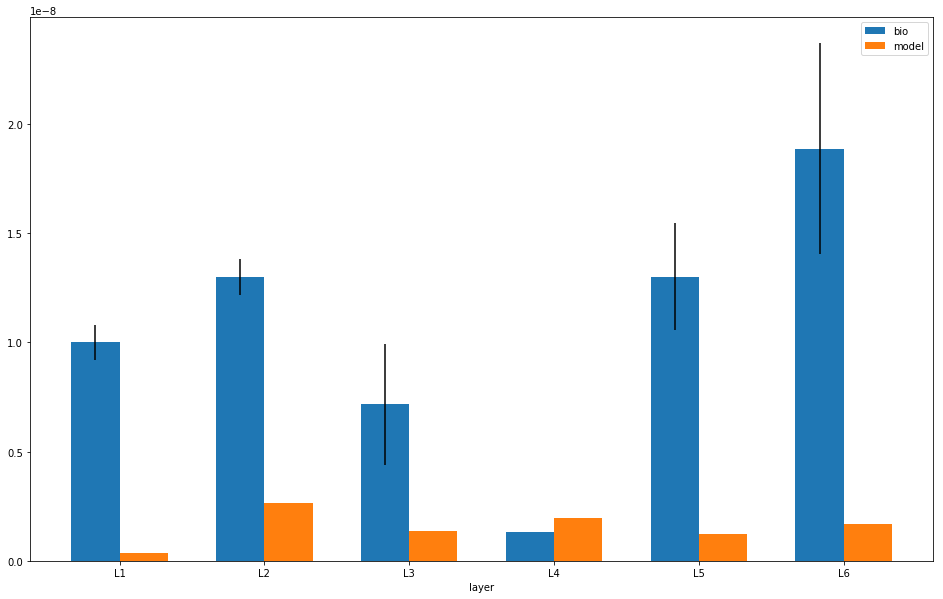

In [4]:
CellDensityValidation(data=example_cell_density_data)(O1Adapter("/gpfs/bbp.cscs.ch/project/proj68/circuits/O1/20190307/CircuitConfig"))

['bio', 'model']   layer  model_samples
0    L1       1.000000
1    L2       0.162407
2    L3       0.093594
3    L4       0.077611
4    L5       0.167481
5    L6       0.093001


{'measurement': 'inhibitory_ratio',
 'plot': <Figure size 1164.98x720 with 1 Axes>}

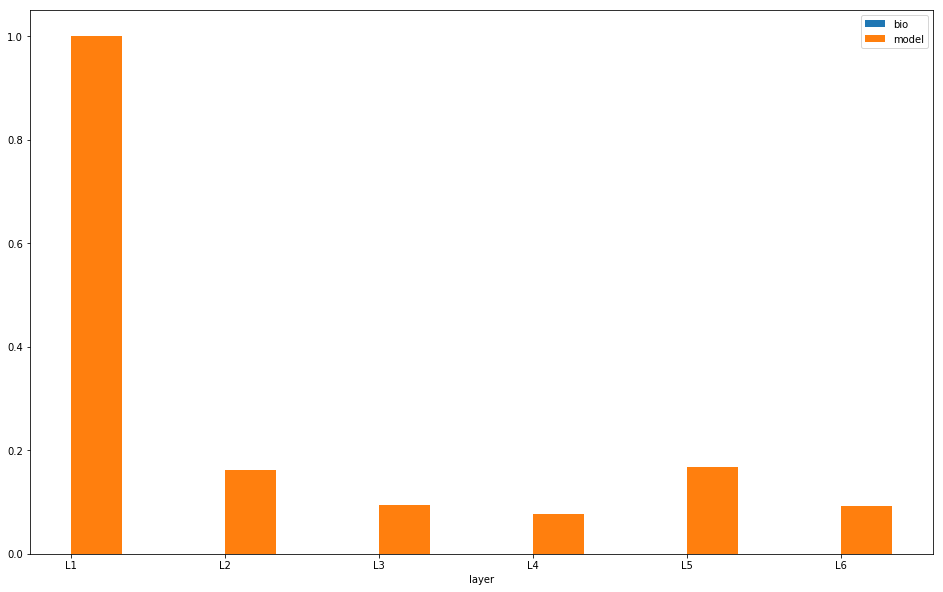

In [5]:
INHRatioValidation(by=[{'layer': l} for l in['L1', 'L2', 'L3', 'L4', 'L5', 'L6']])\
                        (O1Adapter("/gpfs/bbp.cscs.ch/project/proj68/circuits/O1/20190307/CircuitConfig"))